In [2]:
import codecs
import re

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import cross_validate


In [3]:
def load_speaker(path="../data/raw/corpus.tache1.learn.utf8"):
    corpus = []
    classes = []
    f = codecs.open(path, "r", "utf-8")  # pour régler le codage
    while True:
        texte = f.readline()
        if (len(texte)) < 5:
            break
        label = re.sub(r"<\d*:\d*:(.)>.*", "\\1", texte)
        texte = re.sub(r"<\d*:\d*:.>(.*)", "\\1", texte)
        if label.count("M") > 0:
            classes.append(-1)
        else:
            classes.append(1)
        corpus.append(texte)
    return np.array(corpus), np.array(classes)

X, y = load_speaker()
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Comparing original vs oversampling vs undersampling vs balanced for our models


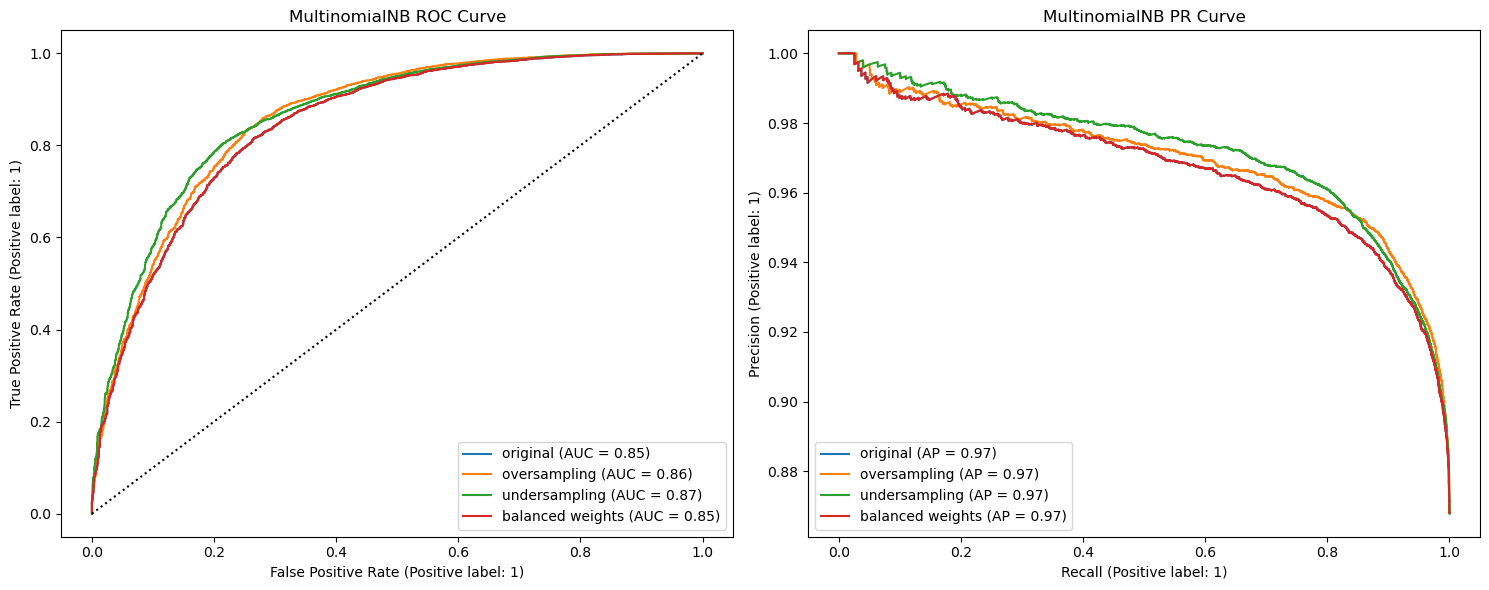

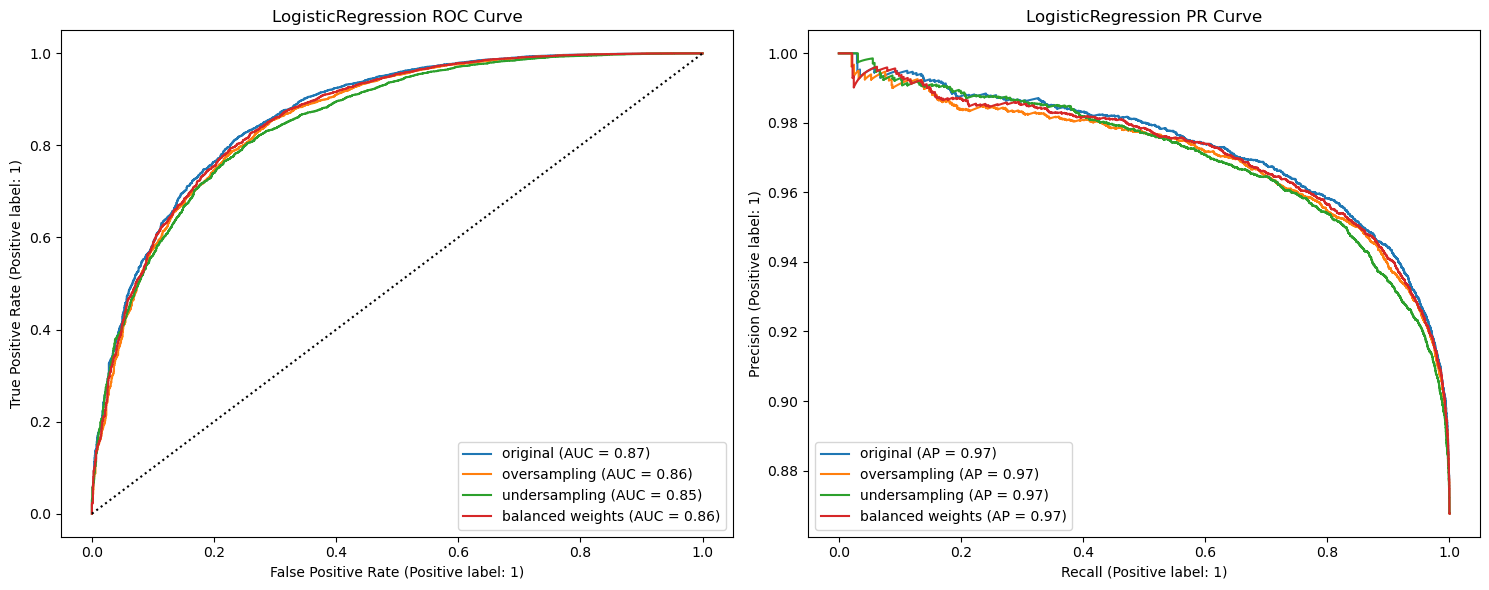

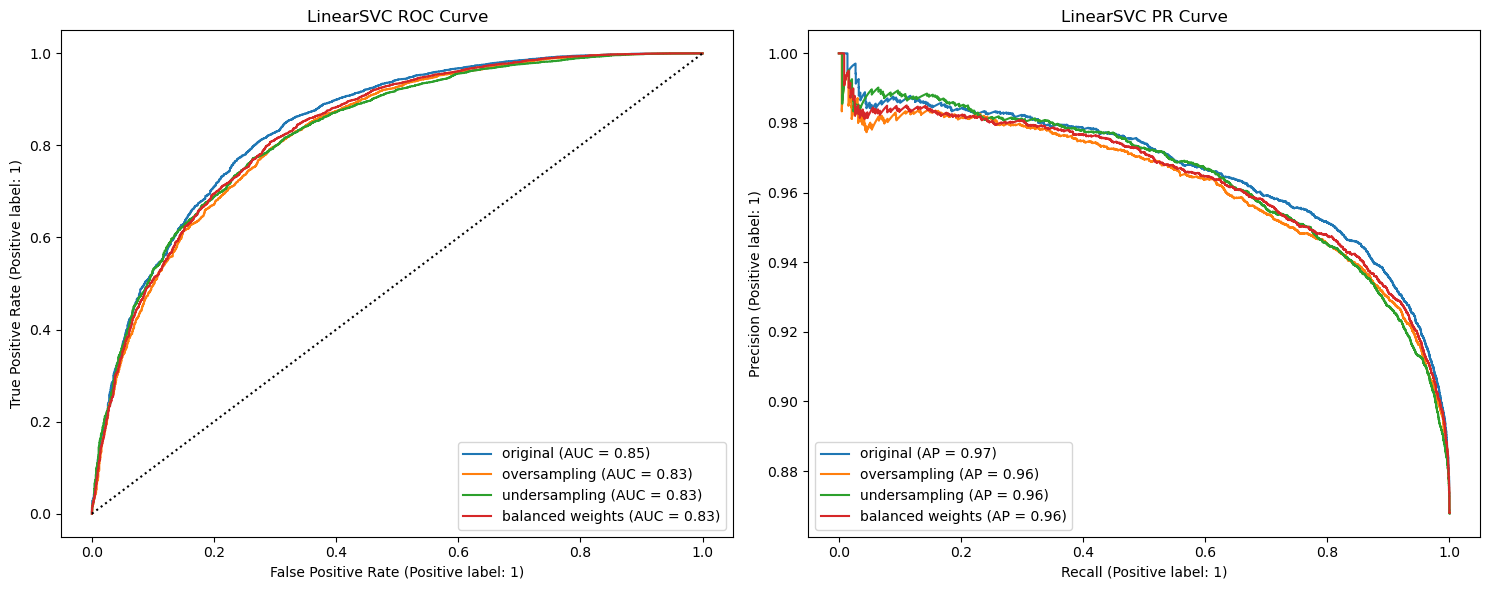

In [10]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

sampler = ["original", "oversampling", "undersampling", "balanced weights"]


def make_pipeline(mode, model):
    if mode == "original":
        return make_imb_pipeline(CountVectorizer(), model())
    elif mode == "oversampling":
        return make_imb_pipeline(CountVectorizer(), RandomOverSampler(), model())
    elif mode == "undersampling":
        return make_imb_pipeline(
            CountVectorizer(), RandomUnderSampler(replacement=False), model()
        )
    elif mode == "balanced weights" and model.__name__ != "MultinomialNB":
        return make_imb_pipeline(CountVectorizer(), model(class_weight="balanced"))
    elif mode == "balanced weights" and model.__name__ == "MultinomialNB":
        return make_imb_pipeline(CountVectorizer(), model(fit_prior=True))


models = [MultinomialNB, LogisticRegression, LinearSVC]

for i, model in enumerate(models):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for sample in sampler:
        pipeline = make_pipeline(sample, model)
        pipeline.fit(X_train, y_train)
        RocCurveDisplay.from_estimator(pipeline, X_test, y_test, name=sample, ax=ax[0])
        PrecisionRecallDisplay.from_estimator(
            pipeline, X_test, y_test, name=sample, ax=ax[1]
        )
    ax[0].set_title(f"{model.__name__} ROC Curve")
    ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
    ax[1].set_title(f"{model.__name__} PR Curve")
    plt.tight_layout()
    plt.show()
